## Retraining Inception Model
Use the lower layers of Google's inception model to make a new classification model on a small data set

In [43]:
import os
import sys
import random
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import urllib
import matplotlib.image as mpimg

INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [2]:
# Helper functions for downloading datasets

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_data(url, path, file):
    if os.path.exists(path):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, file)
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    tgz = tarfile.open(tgz_path)
    tgz.extractall(path=path)
    tgz.close()
    os.remove(tgz_path)

In [3]:
# Download flower dataset

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")
FLOWER_FILE = "flower_photos.tgz"

fetch_data(url=FLOWERS_URL, path=FLOWERS_PATH, file=FLOWER_FILE)

In [4]:
# Get flower directories

flower_dirs = [x[0] for x in os.walk(os.path.join(FLOWERS_PATH,'flower_photos'))][1:]
flower_names = [flower_dir.split('\\')[-1] for flower_dir in flower_dirs]
flowers = list(zip(flower_names,flower_dirs))
flowers

[('daisy', 'datasets\\flowers\\flower_photos\\daisy'),
 ('dandelion', 'datasets\\flowers\\flower_photos\\dandelion'),
 ('roses', 'datasets\\flowers\\flower_photos\\roses'),
 ('sunflowers', 'datasets\\flowers\\flower_photos\\sunflowers'),
 ('tulips', 'datasets\\flowers\\flower_photos\\tulips')]

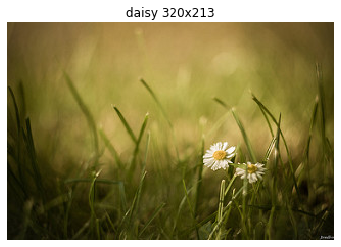

In [5]:
# Show random image

rand_flower = random.choice(flowers)
rand_file  = random.choice([x for x in os.listdir(rand_flower[1]) 
                             if os.path.isfile(os.path.join(rand_flower[1], x))])

random_img = mpimg.imread(os.path.join(rand_flower[1],rand_file))
plt.imshow(random_img)
plt.title("{} {}x{}".format(rand_flower[0],random_img.shape[1], random_img.shape[0]))
plt.axis("off")
plt.show()

In [6]:
# Helper function for preprocessing an image

from skimage.transform import resize

def prepare_image(image, target_width, target_height, max_zoom):
    
    # Generate dimensions proportional to the target dimensions
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Add a random amount of zoom
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Choose random location of image
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    # Random Flip
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Crop and resize image
    return resize(image[y0:y1, x0:x1], (target_width, target_height)).astype(np.float32)

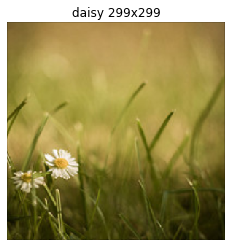

In [17]:
# Show preprocessed image

clean_img = prepare_image(random_img, 299, 299, .2)

plt.imshow(clean_img)
plt.title("{} {}x{}".format(rand_flower[0],clean_img.shape[1], clean_img.shape[0]))
plt.axis("off")
plt.show()

In [18]:
# Build graph with only outer layer being trained

from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
y = tf.placeholder(tf.int32, shape=[None])

# Inception model
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)

# Restore inception model
inception_saver = tf.train.Saver()
    
# New layer for training
with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(tf.squeeze(end_points["PreLogits"], axis=[1, 2]), len(flowers), name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")


# Train outer layers
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

# Accuracy
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [92]:
# Collect data

from sklearn.model_selection import train_test_split

data = pd.DataFrame([[image, flower[1], flower[0]] for flower in flowers 
            for image in os.listdir(flower[1]) 
                if os.path.isfile(os.path.join(flower[1], image))], columns = ['file', 'dir', 'flower'])

unique_values = data.groupby(['flower']).count().reset_index().reset_index()[['index','flower']]
data = data.merge(unique_values)

x_train, x_test, y_train, y_test = train_test_split(data[['file','dir']], data['index'], test_size=.1, stratify=data['index'])
x_train, y_train = x_train.reset_index(drop=True), y_train.reset_index(drop=True)

In [111]:
# Helper function for getting a batch

def get_batch(X, y, size):
    idx = X.sample(n=size).index
    return np.asarray([prepare_image(mpimg.imread(os.path.join(row[2], row[1])), 299, 299, .2) 
            for row in X.iloc[idx,:].itertuples()]), y[idx]
    

In [112]:
# Train Inception model

n_epochs = 8
batch_size = 40
n_iterations_per_epoch = len(y_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = get_batch(x_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Last batch accuracy:", acc_batch)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
Epoch 0..................................................................................  Last batch accuracy: 0.8
Epoch 1..................................................................................  Last batch accuracy: 0.95
Epoch 2..................................................................................  Last batch accuracy: 0.9
Epoch 3..................................................................................  Last batch accuracy: 0.9
Epoch 4..................................................................................  Last batch accuracy: 0.95
Epoch 5..................................................................................  Last batch accuracy: 0.975
Epoch 6..................................................................................  Last batch accuracy: 0.925
Epoch 7..................................................................................  Last batch a